Script to plot QVA probability (or level of model agreement) with the colors aggreed per threshold:

contour levels are: [0.01,0.2,0.4,0.6,0.8,1]

| Threshold | Colormap |
|-----------|----------|
| [0.2 - 2[ | Blues    |
| [2 - 5[   | YlOrBr   |
| [5 - 10[  | Reds     | 
| >= 10     | RbPu     |


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cf

from math import floor,ceil

xlocs = [100,110, 120, 130, 140, 150, 160, 170, 179.99999, -170, -160, -150, -140, -130, -120, -110, -100]
clon = 180
bnd = [160,200,-50,-30]
almost_zero = 1e-16


# Colormap settings

In [2]:
thresholds = np.array([0.2,2,5,10])
print(thresholds)

colormaps = {
    0.2: 'Blues',
    2: 'YlOrBr',
    5: 'Reds',
    10: 'RdPu',
}

contour_levels = [0.01,0.2,0.4,0.6,0.8,1]


[ 0.2  2.   5.  10. ]


0 0.2 Blues
1 2.0 YlOrBr
2 5.0 Reds
3 10.0 RdPu


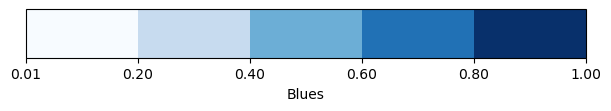

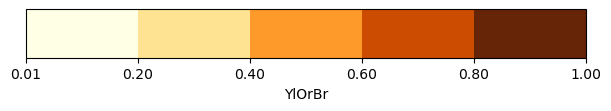

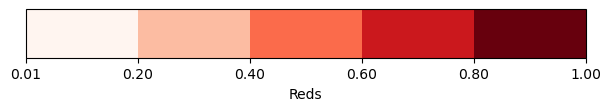

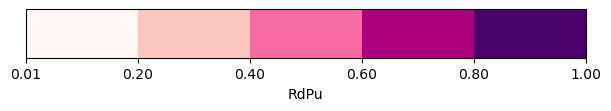

In [3]:
norm = mpl.colors.BoundaryNorm(boundaries=contour_levels, ncolors=256)

for i in range(len(thresholds)):
    print(i, thresholds[i], colormaps[thresholds[i]])
    fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
    fig.colorbar(mpl.cm.ScalarMappable(cmap=colormaps[thresholds[i]], norm=norm),
                cax=ax, orientation='horizontal', label=colormaps[thresholds[i]])#, boundaries=thresholds, ticks=thresholds)


# Read QVA probabilistic netcdf file

In [4]:
ds = xr.open_dataset('../202501_QVA_Exercise/qva_prob_Ruapehu_202501081200.nc')
ds

<xarray.Dataset> Size: 734MB
Dimensions:                 (latitude: 361, longitude: 441, levels: 12,
                             time: 24, thresholds: 4)
Coordinates:
  * latitude                (latitude) float32 1kB -84.28 -84.03 ... 5.47 5.72
  * longitude               (longitude) float32 2kB 120.6 120.8 ... 230.3 230.6
  * levels                  (levels) float64 96B 5e+03 1e+04 ... 5.5e+04 6e+04
  * time                    (time) datetime64[ns] 192B 2025-01-08T13:00:00 .....
  * thresholds              (thresholds) float64 32B 0.2 2.0 5.0 10.0
Data variables:
    frequency_of_excedance  (thresholds, time, levels, latitude, longitude) float32 734MB ...
Attributes:
    title:                            HYSPLIT Model Concentration Output
    Conventions:                      CF-1.5
    volcano_name:                     Ruapehu
    eruption_lon_degrees:             175.57
    eruption_lat_degrees:             -39.28
    eruption_vent_meters_msl:         2797.0
    eruption_height_meters_msl:       12500.0
    eruption_mass_eruption_rate_kgs:  87500.0
    eruption_start_time:              2025-01-08T12:00:00
    eruption_duration_s:              3600.0

## Full extent of the plume at all levels and times

This helps to zoom into the data and allows to have same zoom in all images.

In [5]:
# determine full extent of the plume at all levels and times
da = ds['frequency_of_excedance']
da_m = da.where(da > almost_zero, drop=True)
print(f'before mask = {da.shape}')
print(f'after mask  = {da_m.shape}')

bnd = [floor(da_m.longitude.values.min()), ceil(da_m.longitude.values.max()), 
       floor(da_m.latitude.values.min()), ceil(da_m.latitude.values.max())]
print(f'full extent of plume = {bnd}')

before mask = (4, 24, 12, 361, 441)
after mask  = (4, 24, 12, 42, 124)
full extent of plume = [175, 207, -42, -31]


# Plot probabilistic QVA 

(361, 441)
(361, 441)
(361, 441)
(361, 441)


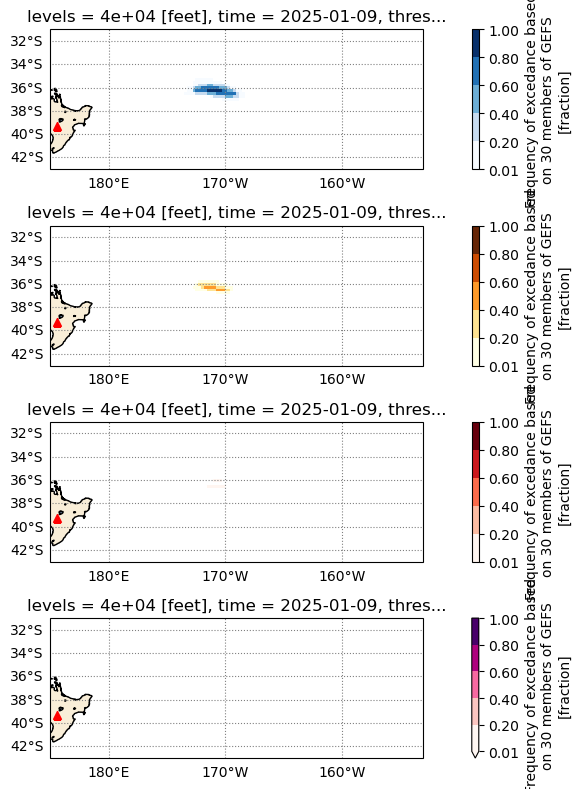

In [6]:
fig, axs = plt.subplots(len(thresholds), 1, figsize=(10,8), subplot_kw={"projection": ccrs.PlateCarree(clon)})

it = 11
ilev = 7
for ithreshold in range(len(thresholds)):
    ax = axs.flatten()[ithreshold]
    da = ds['frequency_of_excedance'].isel(time=it, levels=ilev, thresholds=ithreshold)
    print(da.shape)

    # need to mask to lower countour level so that the lower limit of colorbar is correct (otherwise everything is lower-level color)
    da_m = da.where(da > contour_levels[0])

    cmap = colormaps[thresholds[ithreshold]]
    norm = mpl.colors.BoundaryNorm(boundaries=contour_levels, ncolors=256)
    da_m.plot(ax=ax, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())

    # add volcano location
    ax.plot(ds.attrs['eruption_lon_degrees'], ds.attrs['eruption_lat_degrees'], marker='^' , color='r', transform=ccrs.PlateCarree())

    # zoom in to see the data
    ax.set_extent(bnd)
    # ax.set_extent([175, 180, -40, -35])

    # add decorations 
    # ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.BORDERS, lw=0.5)
    ax.add_feature(cf.LAND, edgecolor='black', facecolor='wheat', linewidth=0.5, alpha=0.5)
    ax.add_feature(cf.LAKES, edgecolor='black', facecolor=cf.COLORS['water']) #'none')
    if clon == 180:
        gl = ax.gridlines(xlocs=xlocs, draw_labels=True, ls=':', color='gray')
    else:
        gl = ax.gridlines(draw_labels=True, ls=':', color='gray')

    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()